## Machine Learning Engineer Capstone Project

Bruno Marques  
October, 2018  


### Tasks:  

Present: 
    1. A proposed DS approach for the initiative;  
    2. The findings of the first week (including at least one predictive model as prototype);  
    3. The suggested next steps.  
    
More specifically, build a **model to predict which employees will leave the company.** 

### About the data:  

For each of 9 years it show employees that are active and those that were terminated.  

The datasets contain: employee id; employee record date ( year of data); birth date; hire date; termination date; age; length of service; city; department; job title; store number; gender; termination reason; termination type; status year; status; business unit  


## STEP 1) Define approach, model goal, expected output and features

**Approach:** Initially an exploratory data analysis will be done using all variables from the original dataset, the goal in this stage is to identify potential correlations and statistically assess the variables. The second stage is to develop a model architecture to predict the values of the evaluation dataset;  
**Model goal:** Understand the correlation between features that results in emplyees leaving the company (trainning phase) and then predict categories for new entries (prediction phase), it will be a categorical model;  
**Expected output:** A binary category, Active (0) or MayLeave (1);    
**Main features:** Features will be divided into two groups, target-feature and main features, as follows:  
    
    Target Feature: A new column, Employee_Status, will be created using the information from the column terminationdate_key column. The value of 1/1/1900 will be considered as Active (0), while any other value will be considered as Left/MayLeave (1);  
    
    Main features: 

            1. EmployeeID: categorical variable, will be used to identify the observations (index);
            2. age: numerical discrete variable;
            3. lenght_of_service: numerical discrete variable;
            4. city_name: categorical variable;
            5. department_name: categorical variable;
            6. store_name: categorical variable encoded as numeric;
            7. gender_short: categorical variable;
            8. STATUS_YEAR: ordinal variable encoded as numeric, only the last observations of each EmployeeID wil be used.
            

## STEP 2) LOAD THE DATA AND CREATE THE TRAINING DATASET AND TARGET_FEATURE

In [1]:
# import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import display

%matplotlib inline

In [2]:
# import statements

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [3]:
# load the 'csv' file
data_filepath = 'data/data_employees.csv'
data_csv = pd.read_csv(data_filepath, index_col='EmployeeID')

# visualize the loaded data
display(data_csv.iloc[:5,:])

,Unnamed: 0,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
EmployeeID,,,,,,,,,,,,,,,,,,
1318,1,12/31/2006 0:00,1/3/1954,8/28/1989,1/1/1900,52,17,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE
1318,2,12/31/2007 0:00,1/3/1954,8/28/1989,1/1/1900,53,18,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE
1318,3,12/31/2008 0:00,1/3/1954,8/28/1989,1/1/1900,54,19,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE
1318,4,12/31/2009 0:00,1/3/1954,8/28/1989,1/1/1900,55,20,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2009,ACTIVE,HEADOFFICE
1318,5,12/31/2010 0:00,1/3/1954,8/28/1989,1/1/1900,56,21,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2010,ACTIVE,HEADOFFICE


In [4]:
# create a function that creates a dataset with the main features only
# input: csv file
# outpu: csv file with selected columns only
def clean_data(file):
    main_features=['age','length_of_service','city_name','department_name','store_name',\
                   'gender_short','STATUS_YEAR']
    slim_dataset = file.loc[:,main_features]
    return(slim_dataset)

In [5]:
# create a function to encode categorical features and remove column STATUS_YEAR
def encode_rm(file):
    new_file = file.drop(['STATUS_YEAR'], axis=1)
    le = LabelEncoder()
    new_file['city_name'] = le.fit_transform(new_file['city_name'])
    new_file['department_name'] = le.fit_transform(new_file['department_name'])
    new_file['gender_short'] = le.fit_transform(new_file['gender_short'])
    
    return(new_file)

In [6]:
# create a raw dataset
raw_data =  clean_data(data_csv)
display(raw_data.iloc[0:5,:])

,age,length_of_service,city_name,department_name,store_name,gender_short,STATUS_YEAR
EmployeeID,,,,,,,
1318,52,17,Vancouver,Executive,35,M,2006
1318,53,18,Vancouver,Executive,35,M,2007
1318,54,19,Vancouver,Executive,35,M,2008
1318,55,20,Vancouver,Executive,35,M,2009
1318,56,21,Vancouver,Executive,35,M,2010


In [7]:
# filter raw_data so it holds only the last entry of STATUS_YEAR. This approach is based in the hypotesys that 
# previous years holds little value to predict the chance of leaving the job, normally decisions are made in 
# the last year
raw_data_last=raw_data.groupby(['EmployeeID']).last() # raw_data_last will be used to build the models
print(raw_data.shape, raw_data_last.shape) # compare the dimensionality reduction

(44692, 7) (6284, 7)


In [8]:
# create the target feature list
Employee_Status = data_csv.loc[:,['terminationdate_key']]
Employee_Status['Employee_Status'] = [0 if i == '1/1/1900' else 1 \
                                   for i in Employee_Status['terminationdate_key']]

employee_Status_last = Employee_Status.groupby(['EmployeeID']).last()
target_status = employee_Status_last.drop(['terminationdate_key'], axis=1)

display(target_status.iloc[:5,:])
print(target_status.shape)

,Employee_Status
EmployeeID,
1318,0
1319,0
1320,0
1321,0
1322,0


(6284, 1)


Now that all three necessary datasets are ready, data_csv for exploratory data analysis (EDA), raw_data_last and target_status to train the models, it is possible to begin the EDA.

## STEP 3) EXPLORATORY DATA ANALYSIS

In [9]:
# sort data by EmployeeID and STATUS_YEAR
eda_data = data_csv.copy()
eda_data=eda_data.groupby(['EmployeeID']).last() # once again using only last year data of each employee
eda_data=pd.concat([eda_data, target_status], axis=1) # concatenated target_status to use as an easier reference
eda_data.drop(['Unnamed: 0'], axis=1, inplace=True)
display(eda_data.iloc[:5,:])
print(eda_data.shape)

,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT,Employee_Status
EmployeeID,,,,,,,,,,,,,,,,,,
1318,12/31/2014 0:00,1/3/1954,8/28/1989,1/1/1900,60,25,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2014,ACTIVE,HEADOFFICE,0
1319,12/31/2014 0:00,1/3/1957,8/28/1989,1/1/1900,57,25,Vancouver,Executive,VP Stores,35,F,Female,Not Applicable,Not Applicable,2014,ACTIVE,HEADOFFICE,0
1320,12/31/2014 0:00,1/2/1955,8/28/1989,1/1/1900,59,25,Vancouver,Executive,Legal Counsel,35,F,Female,Not Applicable,Not Applicable,2014,ACTIVE,HEADOFFICE,0
1321,12/31/2014 0:00,1/2/1959,8/28/1989,1/1/1900,55,25,Vancouver,Executive,VP Human Resources,35,M,Male,Not Applicable,Not Applicable,2014,ACTIVE,HEADOFFICE,0
1322,12/31/2014 0:00,1/9/1958,8/31/1989,1/1/1900,56,25,Vancouver,Executive,VP Finance,35,M,Male,Not Applicable,Not Applicable,2014,ACTIVE,HEADOFFICE,0


(6284, 18)


In [10]:
# create a dataframe only with cases of employess who left
left_eda_data=eda_data[eda_data['Employee_Status'] == 1].copy()
left_eda_data.drop(['Employee_Status'], axis=1, inplace=True)

In [11]:
# compare the quantities of employees who left and those who stayed
left = left_eda_data.shape[0]
percent_left = 100 * left / eda_data.shape[0]
remain = eda_data.shape[0]-left_eda_data.shape[0]
total = eda_data.shape[0]
women_left = left_eda_data[left_eda_data['gender_full'] == 'Female'].shape[0]
percent_women = 100 * women_left / left
men_left = left_eda_data.shape[0] - women_left
percent_men = 100 * men_left/ left

print("Of a total of {} employees {} decided to leave the company, represening a turnover of {:.2f}%.".format(\
                                                                        total, left, percent_left))
print("Of the {} employees who left {} ({:.2f}%) were women and {} ({:.2f}%) were men.".format(left, \
                                                            women_left, percent_women, men_left, percent_men))

Of a total of 6284 employees 1485 decided to leave the company, represening a turnover of 23.63%.
Of the 1485 employees who left 915 (61.62%) were women and 570 (38.38%) were men.


In [12]:
print(left_eda_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1485 entries, 1338 to 8321
Data columns (total 17 columns):
recorddate_key         1485 non-null object
birthdate_key          1485 non-null object
orighiredate_key       1485 non-null object
terminationdate_key    1485 non-null object
age                    1485 non-null int64
length_of_service      1485 non-null int64
city_name              1485 non-null object
department_name        1485 non-null object
job_title              1485 non-null object
store_name             1485 non-null int64
gender_short           1485 non-null object
gender_full            1485 non-null object
termreason_desc        1485 non-null object
termtype_desc          1485 non-null object
STATUS_YEAR            1485 non-null int64
STATUS                 1485 non-null object
BUSINESS_UNIT          1485 non-null object
dtypes: int64(4), object(13)
memory usage: 208.8+ KB
None


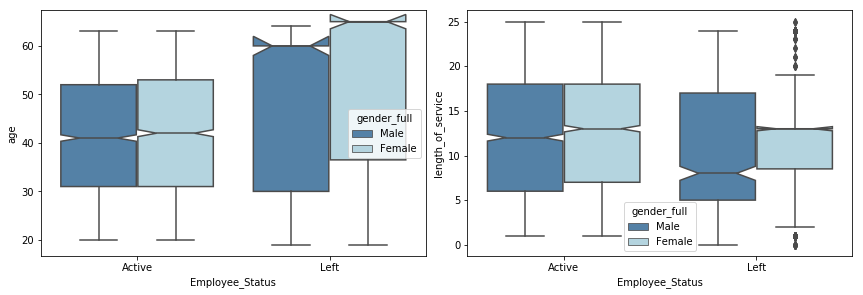

In [13]:
# Boxplots of 'age' and 'length_of_service' (the only two numerical fetures)
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.tight_layout()
ax=sb.boxplot(y="age", x='Employee_Status',hue="gender_full", palette=["steelblue", "lightblue"], \
              data=eda_data,ax=axes[0], notch=True)
ax.set_xticklabels(['Active', 'Left'], fontdict=None, minor=False);

ax1=sb.boxplot(y="length_of_service", x='Employee_Status',hue="gender_full", palette=["steelblue", "lightblue"], \
               data=eda_data,ax=axes[1], notch=True)
ax1.set_xticklabels(['Active', 'Left'], fontdict=None, minor=False);

In [14]:
# statistial analysis of age and length of service
print("All cases:\n",left_eda_data.loc[:,['age','length_of_service']].describe())
print("\nFemale who left:\n",left_eda_data[left_eda_data['gender_full']=='Female'].loc[:,['age','length_of_service']].describe())
print("\nMale who left:\n",left_eda_data[left_eda_data['gender_full']=='Male'].loc[:,['age','length_of_service']].describe())

All cases:
                age  length_of_service
count  1485.000000        1485.000000
mean     51.349495          11.277441
std      16.525395           6.660707
min      19.000000           0.000000
25%      34.000000           7.000000
50%      60.000000          13.000000
75%      65.000000          13.000000
max      65.000000          25.000000

Female who left:
               age  length_of_service
count  915.000000         915.000000
mean    53.779235          12.336612
std     16.521434           6.446915
min     19.000000           0.000000
25%     36.500000           8.500000
50%     65.000000          13.000000
75%     65.000000          13.000000
max     65.000000          25.000000

Male who left:
               age  length_of_service
count  570.000000         570.000000
mean    47.449123           9.577193
std     15.781183           6.651652
min     19.000000           0.000000
25%     30.000000           5.000000
50%     60.000000           8.000000
75%     60.000000 

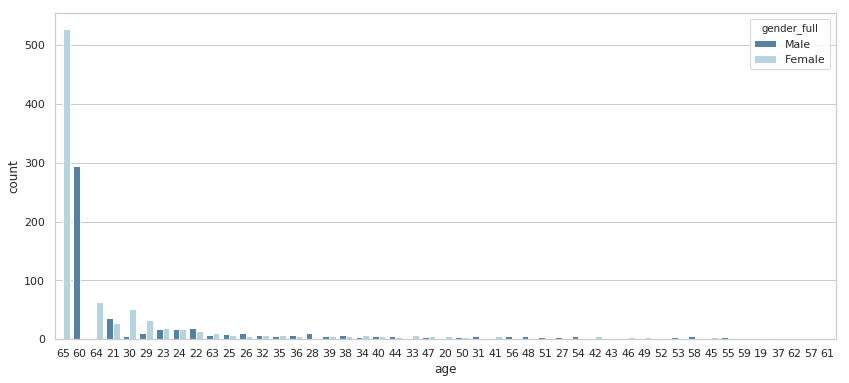

In [15]:
# Countplot - 'age'
sb.set(style='whitegrid', palette="deep", rc={'figure.figsize':(14, 6)})
sb.countplot(x='age', palette=["steelblue", "lightblue"], data=left_eda_data, \
               order=left_eda_data['age'].value_counts().index, hue='gender_full');

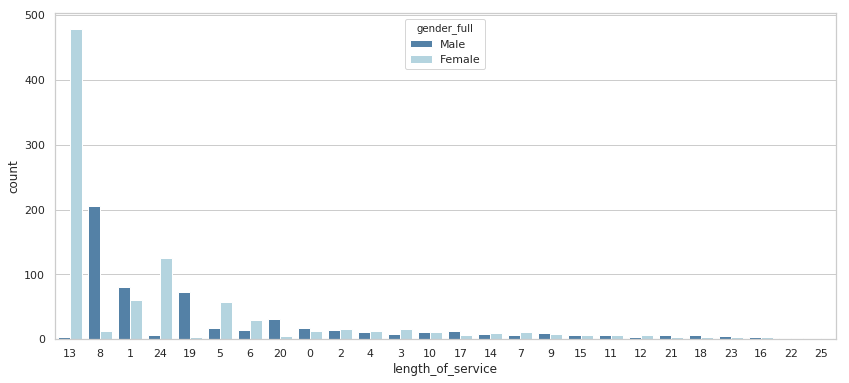

In [16]:
# Countplot - 'length_of_service'
sb.set(style='whitegrid', palette="deep", rc={'figure.figsize':(14, 6)})
sb.countplot(x='length_of_service', palette=["steelblue", "lightblue"], data=left_eda_data, \
               order=left_eda_data['length_of_service'].value_counts().index, hue='gender_full');

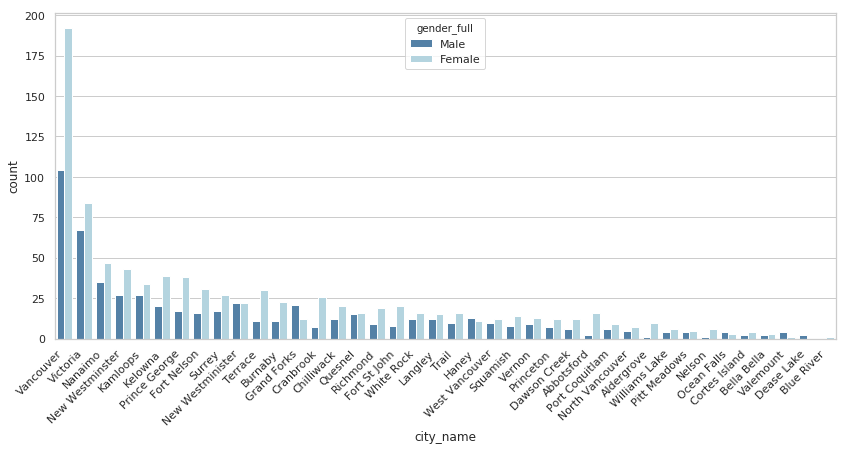

In [17]:
# Countplot - 'city_name'
sb.set(style='whitegrid', palette="deep", rc={'figure.figsize':(14, 6)})
ax1=sb.countplot(x='city_name', palette=["steelblue", "lightblue"], data=left_eda_data, \
               order=left_eda_data['city_name'].value_counts().index, hue='gender_full')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45, ha='right');

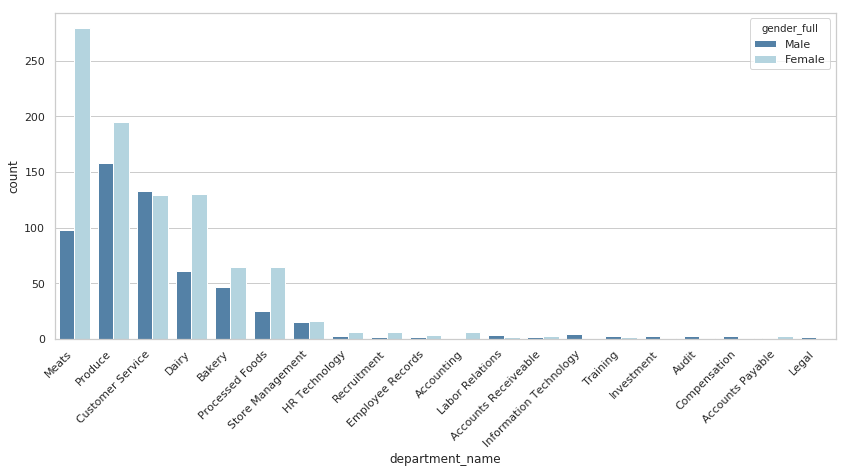

In [18]:
# Countplot - 'department_name'
sb.set(style='whitegrid', palette="deep", rc={'figure.figsize':(14, 6)})
ax1=sb.countplot(x='department_name', palette=["steelblue", "lightblue"], data=left_eda_data, \
               order=left_eda_data['department_name'].value_counts().index, hue='gender_full')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45, ha='right');

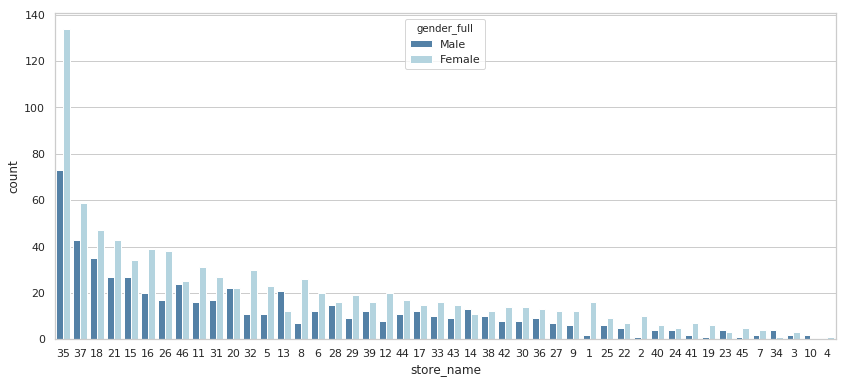

In [19]:
# Countplot - 'store_name'
sb.set(style='whitegrid', palette="deep", rc={'figure.figsize':(14, 6)})
ax1=sb.countplot(x='store_name', palette=["steelblue", 'lightblue'], data=left_eda_data, \
               order=left_eda_data['store_name'].value_counts().index, hue='gender_full')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=0, ha='center');

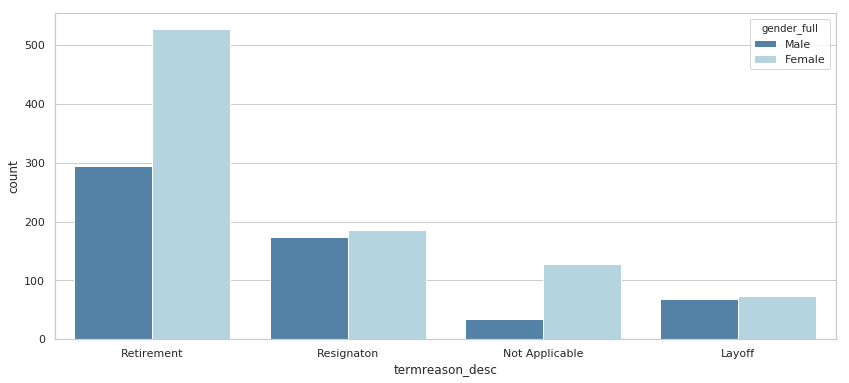

In [20]:
# Countplot - 'termreason_desc'
sb.set(style='whitegrid', palette="deep", rc={'figure.figsize':(14, 6)})
ax1=sb.countplot(x='termreason_desc', palette=["steelblue", "lightblue"], data=left_eda_data, \
               order=left_eda_data['termreason_desc'].value_counts().index, hue='gender_full')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=0, ha='center');

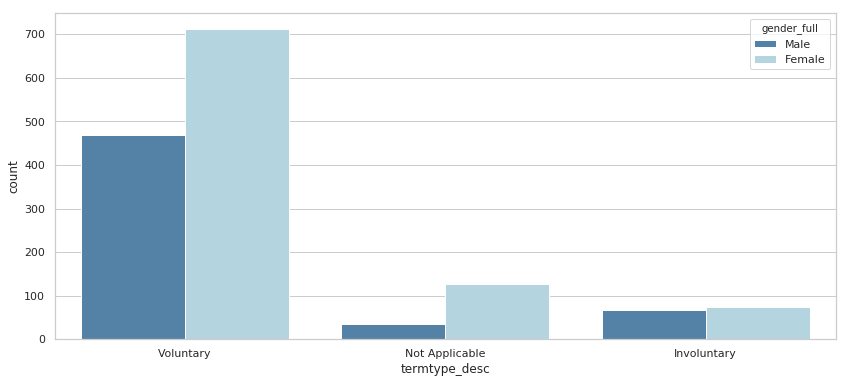

In [21]:
# Countplot - 'termtype_desc'
sb.set(style='whitegrid', palette="deep", rc={'figure.figsize':(14, 6)})
ax1=sb.countplot(x='termtype_desc', palette=["steelblue", "lightblue"], data=left_eda_data, \
               order=left_eda_data['termtype_desc'].value_counts().index, hue='gender_full')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=0, ha='center');

In [22]:
encoded_left=encode_rm(left_eda_data)

/Users/bruno/anaconda3/envs/py3_tensorflow/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


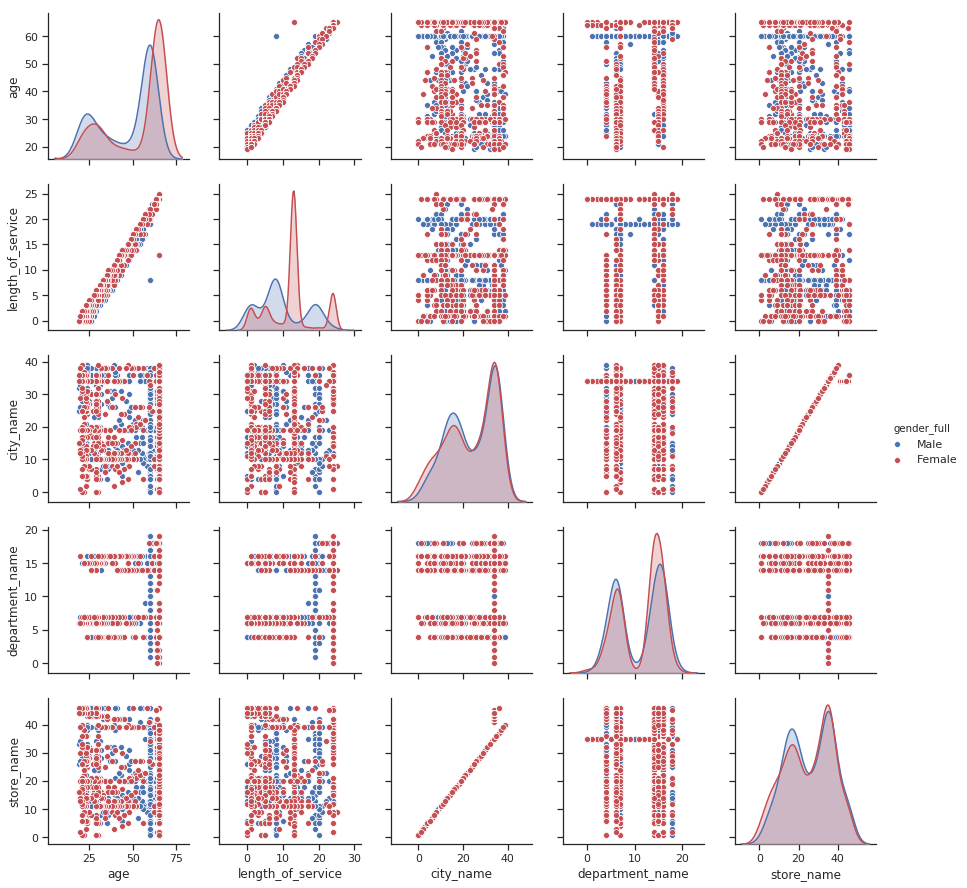

In [23]:
# scatterplot between numerical features
sb.set(style="ticks", palette="deep", rc={'figure.figsize':(8, 6)})
b=sb.pairplot(data=encoded_left.loc[:,['age','length_of_service','city_name','department_name',\
                                       'store_name','gender_full']], palette=["b", "r"], hue='gender_full')

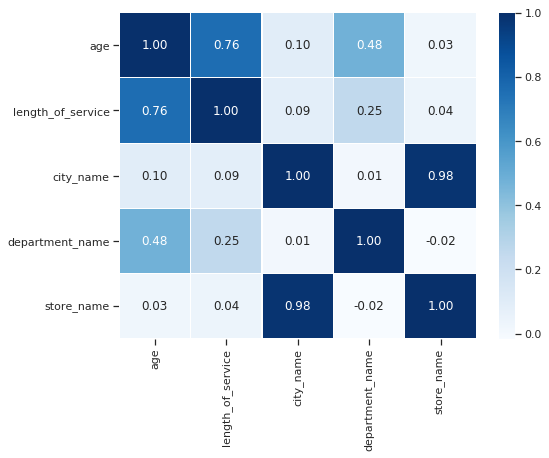

In [24]:
# heatmap to assess correlation between numerical features
sb.heatmap(encoded_left.loc[:,['age','length_of_service','city_name','department_name',\
                                       'store_name','gender_full']].corr(), \
           cmap ='Blues', annot=True, fmt='.2f', linewidths=.1);
plt.show();

### Observations of the Exploratory Data Analysis

Of a total of 6284 employees 1485 decided to leave the company, represening a turnover of 23.63%.
Of the 1485 employees who left 915 (61.62%) were women and 570 (38.38%) were men.

**About the data:**

1) the oldest employees whom leave the company are no more than 65 years old and have no more than 25 years in service;  
2) women tend to leave at older ages than men, 65 against 60 years old respectively, and the range of 60-65 is the one with most occurrencies of employee's turnover;    
3) women with 13 years of service have a really high rate of leaving, with men there is a considerable amount at 8 years of service;  
4) Vancouver and Victoria are the two cities with more turnover, being Vancouver with the highest women turnover;  
5) department areas of meats, produce, customer service and diary holds the higher rates of employees leaving, beeing meats the greatest one specially for women;  
6) store 35 holds the higher rates of employees leaving, also for women is the higher rate store;  
7) retirement is the main reason for leaving, beeing the main motive to most women and men;  
8) pratically all turnover is voluntary;  
9) there is a positive linear relation between age and length_of_service, this means that for a model one of the two could be discarded as the other would carry the same information, the same applies to city and store;  
10) lastly, the heatmap shows the strenght of the age and length_of_service,  city and store pairs relation indeed are strong (values above 0.7).

### STEP 4) BUILD MODEL ARCHITECTURE

Based on the data structure and feature's types the following model was chosen to be tested:  
    
    - Logistic Regression: this is a simple model based on a linear equation, it separates the outputs with a single line, each side of the line represent a category. Besides it’s name, Logistic Regression, is model often used in classification problems;  

In [25]:
print(target_status.sum())
print(target_status.shape)

Employee_Status    1485
dtype: int64
(6284, 1)


In [26]:
# before start with the models prepare the trainning data as the quantity of cases leaving the company are not
# balanced with the cases that remained
raw_data_last.reindex(target_status.index)
raw_data_last = pd.concat([raw_data_last, target_status], axis=1)

df_majority = raw_data_last[raw_data_last['Employee_Status']==0]
df_minority = raw_data_last[raw_data_last['Employee_Status']==1]

In [27]:
print(df_majority.shape, df_minority.shape)

(4799, 8) (1485, 8)


In [28]:
# balance data
df_minority_balaced = resample(df_minority, 
                            replace=True,    
                            n_samples=df_majority.shape[0],    
                            random_state=7) 
 
# combine both dataframes
train_balaced = pd.concat([df_majority, df_minority_balaced])
 
# count new values
train_balaced['Employee_Status'].value_counts()

1    4799
0    4799
Name: Employee_Status, dtype: int64

In [29]:
# separate the target feature from the dataframe
target_status_balanced = train_balaced.loc[:,['Employee_Status']].astype('int')
r, c = target_status_balanced.shape
target_status_balanced = target_status_balanced.values.reshape(r,)
train_balaced.drop(['Employee_Status'], axis=1, inplace=True)
print(target_status_balanced.shape, train_balaced.shape)

(9598,) (9598, 7)


In [30]:
display(train_balaced.iloc[:5,:])

,age,length_of_service,city_name,department_name,store_name,gender_short,STATUS_YEAR
EmployeeID,,,,,,,
1318,60,25,Vancouver,Executive,35,M,2014
1319,57,25,Vancouver,Executive,35,F,2014
1320,59,25,Vancouver,Executive,35,F,2014
1321,55,25,Vancouver,Executive,35,M,2014
1322,56,25,Vancouver,Executive,35,M,2014


In [31]:
train_encoded = encode_rm(train_balaced)

In [32]:
# divide the data into train and test
X_train, X_test, y_train, y_test = train_test_split(train_encoded.values,\
                                                    target_status_balanced, test_size=0.25, random_state=7)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7198, 6)
(7198,)
(2400, 6)
(2400,)


In [40]:
# test the different models and assess which one has the best score
pipeline = []
pipeline.append(('LR', Pipeline([('LR', LogisticRegression(solver='lbfgs'))])))

results = []
names = []
for name, model in pipeline:
    kfold = KFold(n_splits=20, random_state=7)
    cv_results_train = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results_train)
    names.append(name)
    msg1 = "Train result of model %s: mean accuracy - %f (std: %f)" % \
    (name, cv_results_train.mean(), cv_results_train.std())
    print(msg1)

Train result of model LR: mean accuracy - 0.848427 (std: 0.017548)


In [41]:
# perform a gridsearch to find the best parameters
params = {'penalty':['l2'],\
          'C': [0.01, 0.03, 0.05],
          'solver': ['lbfgs', 'liblinear', 'saga'],\
          'max_iter':[3000, 4000]}

model = LogisticRegression()
kfold = KFold(n_splits=20, random_state=7)
grid = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=kfold, verbose=1)

grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 20 folds for each of 18 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  6.3min finished


0.852459 (0.015980) with: {'solver': 'lbfgs', 'max_iter': 3000, 'C': 0.01, 'penalty': 'l2'}
0.734093 (0.028873) with: {'solver': 'liblinear', 'max_iter': 3000, 'C': 0.01, 'penalty': 'l2'}
0.850931 (0.016244) with: {'solver': 'saga', 'max_iter': 3000, 'C': 0.01, 'penalty': 'l2'}
0.852459 (0.015980) with: {'solver': 'lbfgs', 'max_iter': 4000, 'C': 0.01, 'penalty': 'l2'}
0.734093 (0.028873) with: {'solver': 'liblinear', 'max_iter': 4000, 'C': 0.01, 'penalty': 'l2'}
0.850931 (0.016244) with: {'solver': 'saga', 'max_iter': 4000, 'C': 0.01, 'penalty': 'l2'}
0.851903 (0.017893) with: {'solver': 'lbfgs', 'max_iter': 3000, 'C': 0.03, 'penalty': 'l2'}
0.780772 (0.022750) with: {'solver': 'liblinear', 'max_iter': 3000, 'C': 0.03, 'penalty': 'l2'}
0.853293 (0.017883) with: {'solver': 'saga', 'max_iter': 3000, 'C': 0.03, 'penalty': 'l2'}
0.851903 (0.017893) with: {'solver': 'lbfgs', 'max_iter': 4000, 'C': 0.03, 'penalty': 'l2'}
0.780772 (0.022750) with: {'solver': 'liblinear', 'max_iter': 4000, 'C'

In [35]:
model = LogisticRegression(penalty='l2', C=0.03, max_iter= 3000, solver= 'saga')
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print (accuracy_score(y_test, predictions))                               

0.86375


In [36]:
compare = pd.DataFrame({'Prediction': predictions, 'Test Data' : y_test})
display(compare.iloc[:15,:])

,Prediction,Test Data
0,1,1
1,1,1
2,0,1
3,1,1
4,0,0
5,0,0
6,1,1
7,0,0
8,1,1
9,1,1


In [42]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods

    title : Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.

    n_jobs : int or None, optional (default=None)

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


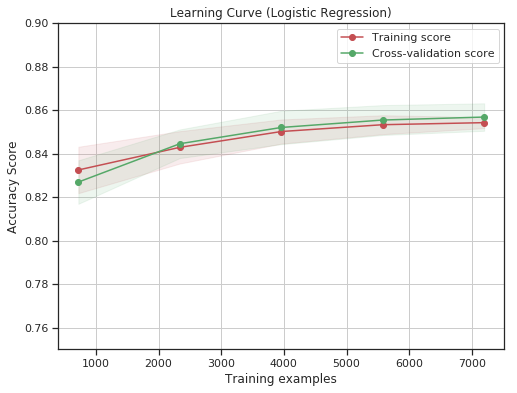

In [45]:
title = "Learning Curve (Logistic Regression)"

cv = ShuffleSplit(n_splits=20, test_size=0.25, random_state=7)
estimator = model
plot_learning_curve(estimator, title, train_encoded, target_status_balanced, \
                    (0.75, 0.9), cv=cv, n_jobs=-1)

plt.show()

In [ ]:
# load the 'eval_set.csv' file
eval_filepath = 'data/eval_set.csv'
eval_csv = pd.read_csv(eval_filepath, index_col='EmployeeID')

eval_set = clean_data(eval_csv)
eval_set = encode_rm(eval_set)

# visualize the loaded data
display(eval_set.iloc[:5,:])

In [ ]:
# predict values of eval_set
eval_predictions = model.predict(eval_set)

In [ ]:
# create a dataframe with the indexes and predictions
model_prediction = pd.DataFrame(data=eval_predictions, index=eval_set.index, columns=['Employee_May_Left'])

In [ ]:
# salve the dataframe as csv
model_prediction.to_csv('model_prediction.csv', sep=',')